# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [4]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [5]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

In [7]:
w = data[data.race=='w']
b = data[data.race=='b']

# Question 1: 

**What test is appropriate for this problem? Does CLT apply?**

- Hypothesis test with the sampling distribution of the sample proportion. Normal distribution to approximate binomial probabilities. The Central Limit Theorem is the tool that allows us to do so.
- Permutation test
- Binomial distribution test

Discuss with Andrei: which method is the appropriate one for this binomial distribution

# Question 2:

** What are the null and alternate hypothesis?**

- Null: the black-sounding or white-sounding names don't determine the requests for interviews from employers
- Alternate: black-sounding names drive less requests for interviews from employers


# Question 3:

**Permutation:**

In [28]:
b.shape

(2435, 65)

In [29]:
w.shape

(2435, 65)

In [14]:
w[w.call == 1].shape

(235, 65)

In [15]:
w[w.call == 0].shape

(2200, 65)

In [16]:
b[b.call == 1].shape

(157, 65)

In [17]:
b[b.call == 0].shape

(2278, 65)

In [22]:
b_1 = b[b.call == 1]
w_1 = w[w.call == 1]

In [130]:
# Difference in proportion from sample data:

prop_b = b_1.shape[0] / b.shape[0]
prop_w = w_1.shape[0] / w.shape[0]

diff = prop_b - prop_w
diff

prop_w

0.09650924024640657

In [131]:
# probability of getting a request for an interview from sample data, regardless of name:

data_1 = data[data.call == 1]

prob_1 = data_1.shape[0] / data.shape[0]
prob_1

# if null hypothesis is true, the proportion for black and white sounding names should be prob_1

0.08049281314168377

In [132]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [133]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [134]:
np.random.seed(40)

# Construct arrays of data: black-sounding, white_sounding names:
b_names = np.array([True] * 157 + [False] * 2278)
w_names = np.array([True] * 235 + [False] * 2200)

def frac_yes_black(data_perm_1, data_perm_2):
    """Compute fraction of black-sounding names with a request."""
    frac = np.sum(data_perm_1) / len(data_perm_1)
    return frac

# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(b_names, w_names, frac_yes_black, 10000)

# Compute and print p-value: p
p = np.sum(perm_replicates >= prob_1) / len(perm_replicates)
print('p-value =', p)


p-value = 0.5216


High p-value accepts the null hypothesis that the difference in proportion of black-sounding name and white-sounding name getting a request for interview is due to chance.

**Bootstrap:**

In [57]:
def perform_bernoulli_trials(n, p):
    """Perform n Bernoulli trials with success probability p
    and return number of successes."""
    # Initialize number of successes: n_success
    n_success = 0

    # Perform trials
    for i in range(n):
        # Choose random number between zero and one: random_number
        random_number = np.random.random()

        # If less than p, it's a success so add one to n_success
        if random_number < p:
            n_success += 1

    return n_success

In [58]:
# probability of getting a request for an interview from sample data, regardless of name:

data_1 = data[data.call == 1]

prob_1 = data_1.shape[0] / data.shape[0]
prob_1

# if null hypothesis is true, the proportion for black and white sounding names should be prob_1

0.08049281314168377

In [85]:
# Seed random number generator
np.random.seed(42)

# Initialize the number of requests: n_requests
n_requests = np.empty(1000)

# Compute the number of requests for job interview:
for i in range(1000):
    n_requests[i] = perform_bernoulli_trials(100, prob_1)

# calculate proportion:
n_requests_prop = n_requests / 100

# calculate proportion of less or same as black_sounding names proportion from dataset:

p = np.sum(n_requests_prop <= prop_b) / len(n_requests_prop)
print('prop =', p)


prop = 0.284


28.4% of the bootstrap sample has a proportion lower or the same as the one for black-sounding names that got a request for job interview

Discuss with Andrei: is this the right analysis for bootstrap? Or should I do a two-sample bootstrap hypothesis test for difference of proportions?

In [120]:
# Using binomial method for probability of black-sounding names:

np.random.seed(42)
samples_binomial = np.random.binomial(n=b_1.shape[0],p=prop_b, size=10000)
samples_prop = samples_binomial/b_1.shape[0]

np.sum(samples_prop >= prob_1) / len(samples_prop)

0.20810000000000001

20.8% of the bootstrap sample for black-sounding names have a proportion equal or higher to the proportion in the null hypothesis

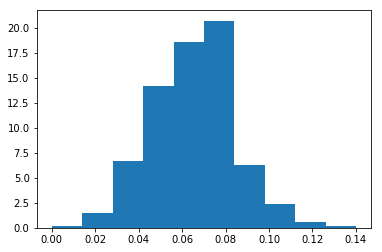

In [128]:
plt.hist(samples_prop, normed=True)
plt.show()

In [129]:
prop_b

0.06447638603696099

In [136]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(samples_prop, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'proportion')

95% confidence interval = [ 0.03184713  0.10191083] proportion


**Frequestist:**

In [94]:
from scipy.stats import sem
from scipy.stats import binom

# Difference in proportion from sample data:

prop_b = b_1.shape[0] / b.shape[0]
prop_w = w_1.shape[0] / w.shape[0]

diff = prop_b - prop_w

# standard error:
sem = binom.std(b.shape[0], prop_b, loc=0) / np.sqrt(len(b))
sem



0.24559963697158382

In [95]:
zscore = diff / sem
zscore      

-0.13042712360829681

In [96]:
import scipy.stats as st
p_value = st.norm.cdf(zscore)
p_value

0.44811425416910133

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>